In [34]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torch.utils.data import Subset,DataLoader, TensorDataset, ConcatDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [35]:
batch_size = 64
num_classes = 10
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [36]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

train_set = datasets.CIFAR10('/content',train=True,download=True,transform=transform)
test_set = datasets.CIFAR10('/content',train=False,download=True,transform=transform)
print(train_set.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)


### Preprocessing

In [37]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = np.transpose(dataset.data,(0,3,1,2)) # get the images
    dataset_labels = dataset.targets # get the labels
    dataset_images = normalize(dataset_images)
    # dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

### Prepare the data

In [38]:
training_set = TensorDataset(torch.Tensor(train_images),torch.Tensor(train_labels).to(torch.int64))
testing_set = TensorDataset(torch.Tensor(test_images),torch.Tensor(test_labels).to(torch.int64))
# print(torch.Tensor(train_labels).to(torch.int64).dtype)

# prepare subset of training data per class 
training_subsets = {target: Subset(training_set,[i for i,(X,y) in enumerate(training_set) if y == target]) for _,target in train_set.class_to_idx.items()}
training_loaders = {target: DataLoader(subset,batch_size=batch_size) for target,subset in training_subsets.items()}

# prepare subset of testing data per class
testing_subsets = {target: Subset(testing_set,[i for i,(X,y) in enumerate(testing_set) if y == target]) for _,target in test_set.class_to_idx.items()}
testing_loaders = {target: DataLoader(subset,batch_size=batch_size) for target,subset in testing_subsets.items()}

In [39]:
print(training_subsets[1].dataset.tensors[1][training_subsets[2].indices])

tensor([2, 2, 2,  ..., 2, 2, 2])


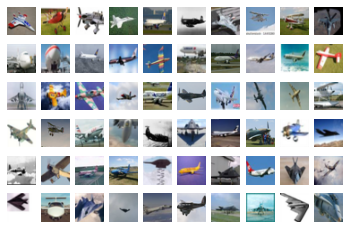

In [40]:
dataiter = iter(training_loaders[0])
images,labels = dataiter.next()
# print(images[0].shape)

figure = plt.figure()
num_of_images = 60
for index in range(1,num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis("off")
  plt.imshow(np.transpose(images[index].numpy(),(1,2,0)))

### Define the network

In [41]:
class NeuralNetwork(nn.Module):
  def __init__(self,classes,channels):
    super().__init__()
    self.conv1 = nn.Conv2d(channels,6,5)
    self.conv2 = nn.Conv2d(6,16,5)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(16*5*5,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,classes)
  
  def forward(self,x):
    # x = x.unsqueeze(1)
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    # x = F.softmax(x,dim=1)
    return x

### Training the model

In [42]:
def train(model,trainloader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
  model = model.to(device)
  model.train()
  for e in range(epochs):
    running_loss = 0.0
    for _,(images,labels) in enumerate(trainloader):
      (images,labels) = (images.to(device),labels.to(device))
      optimizer.zero_grad()

      output = model(images)
      loss = criterion(output,labels)

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    # else:
    #   print(f"Training loss: {running_loss / len(trainloader)}")
  return model

### Testing the model

In [43]:
def test(model,testloader,classes):
  correct = np.zeros(classes,dtype=np.float64)
  total = np.zeros(classes,dtype=np.float64)
  model = model.to(device)

  with torch.no_grad():
    for images,labels in testloader:
      (images,labels) = (images.to(device),labels.to(device))
      output = model(images)
      pred = torch.argmax(output,dim=1)
      for i in range(len(labels)):
        correct[labels[i]] += (pred[i] == labels[i])
        total[labels[i]] += 1
  print(f"Accuracy for {classes} classes: {np.sum(correct) / np.sum(total)}")
  return np.divide(correct,total)

### Prepare initial training set

Accuracy for 2 classes: 0.6875
[0.864 0.511]
Accuracy for 3 classes: 0.691
[0.628 0.748 0.697]
Accuracy for 4 classes: 0.61375
[0.507 0.788 0.652 0.508]
Accuracy for 5 classes: 0.5456
[0.652 0.746 0.245 0.454 0.631]
Accuracy for 6 classes: 0.4688333333333333
[0.573 0.695 0.25  0.339 0.413 0.543]
Accuracy for 7 classes: 0.493
[0.748 0.608 0.368 0.262 0.475 0.338 0.652]
Accuracy for 8 classes: 0.484375
[0.678 0.703 0.328 0.265 0.369 0.386 0.626 0.52 ]
Accuracy for 9 classes: 0.4728888888888889
[0.452 0.834 0.2   0.229 0.212 0.46  0.634 0.643 0.592]
Accuracy for 10 classes: 0.4392
[0.467 0.434 0.312 0.236 0.212 0.316 0.58  0.592 0.682 0.561]
Accuracy for 2 classes: 0.7865
[0.941 0.632]
Accuracy for 3 classes: 0.7363333333333333
[0.708 0.631 0.87 ]
Accuracy for 4 classes: 0.63425
[0.78  0.707 0.321 0.729]
Accuracy for 5 classes: 0.5448
[0.759 0.773 0.093 0.413 0.686]
Accuracy for 6 classes: 0.508
[0.824 0.619 0.326 0.233 0.379 0.667]
Accuracy for 7 classes: 0.4462857142857143
[0.713 0.591 

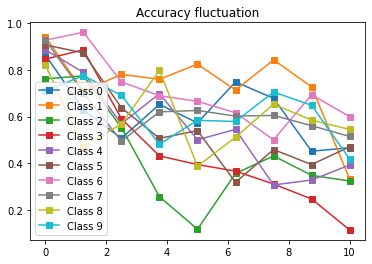

In [44]:
accuracy_changes = [[] for x in range(num_classes)]
x = np.linspace(0,10,num=9)

for class_of_interest in range(num_classes):
  multi_class_train_set = training_subsets[class_of_interest] # create initial datasets
  multi_class_test_set = testing_subsets[class_of_interest] # create initial datasets
  num = 1 # number of classes currently in classifier

  if class_of_interest >= 1:
    train_class_indices = training_set.tensors[1] == class_of_interest
    previous_train_class_indices = training_set.tensors[1] == 0
    training_set.tensors[1][train_class_indices] = 0
    training_set.tensors[1][previous_train_class_indices] = class_of_interest

    test_class_indices = testing_set.tensors[1] == class_of_interest
    previous_test_class_indices = testing_set.tensors[1] == 0
    testing_set.tensors[1][test_class_indices] = 0
    testing_set.tensors[1][previous_test_class_indices] = class_of_interest
    # print(training_set.tensors[1].unique())
    # print(training_subsets[2].dataset.tensors[1][training_subsets[2].indices])
    # break
  for i in range(num_classes):
    if class_of_interest == i:
      continue
    
    num += 1
    model = NeuralNetwork(num,3)
    # concat the training set of the new class with old training set
    multi_class_train_set = ConcatDataset([multi_class_train_set,training_subsets[i]])
    # concat the testing set of the new class with old testing set
    multi_class_test_set = ConcatDataset([multi_class_test_set,testing_subsets[i]])
    # define train loader
    train_loader = DataLoader(multi_class_train_set,batch_size=batch_size,shuffle=True)
    # define test loader
    test_loader = DataLoader(multi_class_test_set,batch_size=batch_size)
    # train the old model with new dataset
    model = train(model,train_loader)
    accuracies = test(model,test_loader,num)
    print(accuracies)
    accuracy_changes[class_of_interest].append(accuracies[0])
  
  
  plt.plot(x,accuracy_changes[class_of_interest],'-s',label = f'Class {class_of_interest}')

plt.legend()
plt.title("Accuracy fluctuation")
plt.show()

### Plot the accuracy variation for class 0

In [45]:
# x = np.linspace(0,10,num=9)
# plt.plot(x,accuracy_change_0,'-s',label = 'Class 0')
# plt.plot(x,accuracy_change_1,'-s',label = 'Class 1')
# plt.legend()
# plt.title("Accuracy fluctuation")
# plt.show()